# Computer Vision  Assignment 2 Part 2a


In [2]:
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T
from tqdm.notebook import tqdm_notebook

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.get_device_name()

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

## Getting data

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        #print('in transform init, rescalling')
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        #print('in transform call')
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return img

In [5]:
IMAGE_RESIZE = (224,224)
transform = T.Compose([
    #Rescale(IMAGE_RESIZE),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


start transforming


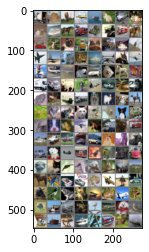

truck      cat        deer       plane      ship       cat        car        dog        cat        ship       horse      truck      frog       horse      truck      horse      car        deer       cat        truck      frog       frog       ship       bird       plane      plane      dog        frog       ship       plane      cat        plane      horse      plane      plane      bird       plane      dog        horse      truck      truck      truck      dog        bird       plane      car        deer       truck      frog       deer       ship       truck      cat        dog        dog        horse      deer       cat        frog       cat        bird       cat        dog        frog       deer       cat        bird       plane      deer       truck      dog        truck      ship       car        bird       truck      car        dog        horse      cat        car        dog        plane      truck      bird       bird       truck      car        bird       cat        plane     

In [6]:
## Checking out some training images

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    print('start transforming')
    img = img / 2 + 0.5     # unnormalize
    # print('1')
    npimg = img.numpy()
    # print('2')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # print('3')
    plt.show()


# get some random training images
# print('start')
dataiter = iter(trainloader)
# print('got dataiter')
images, labels = dataiter.next()
# print('img and labels')
# show images
imshow(torchvision.utils.make_grid(images))
# print('shown img')
# print labels
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

## Part 2a Model (ResNet18 without any training)

In [7]:
resnet18 = models.resnet18(pretrained=False)
resnet18.to(device)
RESNET_PATH_A =  './resnet18_a.pth'
# resnet18.load_state_dict(torch.load(RESNET_PATH_A))

In [8]:
# resnet18 = models.resnet18(pretrained=False)
# print(resnet18)

# Input size of resnet18 -> 224 by 224
# but CIFAR10 has 30*30*3 images

## Training

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# so are we using momentum based SGD (does it has a name)
optimizer = optim.Adam(resnet18.parameters(), lr=1e-3)

In [10]:
epochs = 100
resume_train = False

if resume_train:
    resnet18.load_state_dict(torch.load(RESNET_PATH_A))
    
test_epoch_acc = []
train_epoch_acc = []
for epoch in range(epochs):
    running_loss = 0.0
    train_corrects = 0.0
    total = 0
    resnet18.train()
    for i, data in  tqdm_notebook(enumerate(trainloader, 0)):
        # print('starting')
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # for gpu it will be
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()
        total = labels.size(0)
        
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
            # torch.save(resnet18.state_dict(), RESNET_PATH_A) ### NOT SAVING THE MODEL
    train_epoch_acc.append(train_corrects.double() / len(trainloader.dataset))
    # print('train correct:', train_corrects)
    print('train acc:', train_epoch_acc[-1])
    
    resnet18.eval()
    test_corrects = 0
    for imgs, labels in testloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = resnet18(imgs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
        
        test_corrects += torch.sum(preds == labels.data)
    test_epoch_acc.append(test_corrects.double() / len(testloader.dataset))
    # print('test corrects:', test_corrects)
    print('test acc:', test_epoch_acc[-1])

0it [00:00, ?it/s]

[1,   200] loss: 1.608
train correct: tensor(25443., device='cuda:0')
train acc: tensor(0.5089, device='cuda:0', dtype=torch.float64)
test corrects: tensor(6062, device='cuda:0')
test acc: tensor(0.6062, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[2,   200] loss: 1.002
train correct: tensor(32831., device='cuda:0')
train acc: tensor(0.6566, device='cuda:0', dtype=torch.float64)
test corrects: tensor(6741, device='cuda:0')
test acc: tensor(0.6741, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[3,   200] loss: 0.807
train correct: tensor(36063., device='cuda:0')
train acc: tensor(0.7213, device='cuda:0', dtype=torch.float64)
test corrects: tensor(6780, device='cuda:0')
test acc: tensor(0.6780, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[4,   200] loss: 0.660
train correct: tensor(38273., device='cuda:0')
train acc: tensor(0.7655, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7230, device='cuda:0')
test acc: tensor(0.7230, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[5,   200] loss: 0.543
train correct: tensor(40246., device='cuda:0')
train acc: tensor(0.8049, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7429, device='cuda:0')
test acc: tensor(0.7429, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[6,   200] loss: 0.443
train correct: tensor(41723., device='cuda:0')
train acc: tensor(0.8345, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7437, device='cuda:0')
test acc: tensor(0.7437, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[7,   200] loss: 0.360
train correct: tensor(43273., device='cuda:0')
train acc: tensor(0.8655, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7427, device='cuda:0')
test acc: tensor(0.7427, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[8,   200] loss: 0.287
train correct: tensor(44601., device='cuda:0')
train acc: tensor(0.8920, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7405, device='cuda:0')
test acc: tensor(0.7405, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[9,   200] loss: 0.222
train correct: tensor(45617., device='cuda:0')
train acc: tensor(0.9123, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7226, device='cuda:0')
test acc: tensor(0.7226, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

[10,   200] loss: 0.182
train correct: tensor(46434., device='cuda:0')
train acc: tensor(0.9287, device='cuda:0', dtype=torch.float64)
test corrects: tensor(7567, device='cuda:0')
test acc: tensor(0.7567, device='cuda:0', dtype=torch.float64)


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(resnet18.state_dict(), RESNET_PATH_A)

In [12]:
test_acc = []
train_acc = []
for acc in test_epoch_acc:
    test_acc.append(acc.item())
for acc in train_epoch_acc:
    train_acc.append(acc.item())
print(type(test_acc[0]))

<class 'float'>


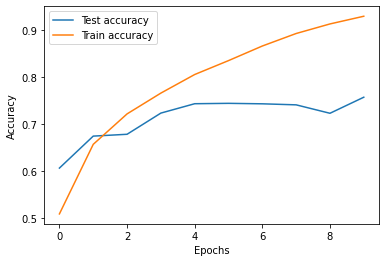

In [13]:
## Testing the trained model
import matplotlib.pyplot as plt
# test_acc = [acc.data for acc in test_epoch_acc]

plt.plot(test_acc, label='Test accuracy')
plt.plot(train_acc, label='Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

start transforming


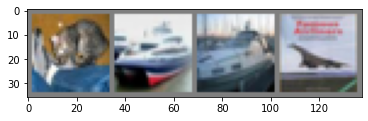

GroundTruth:  cat   ship  ship  plane


In [14]:
# ## just printing some data
# dataiter = iter(testloader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images[:4]))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
# ## Accuracy on Test Data
# correct = 0
# total = 0
# resnet18.load_state_dict(torch.load(RESNET_PATH_A))
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data[0].to(device), data[1].to(device)
#         # calculate outputs by running images through the network
#         outputs = resnet18(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %


In [12]:
# ## Accuracy on train data
# correct = 0
# total = 0
# resnet18.load_state_dict(torch.load(RESNET_PATH_A))
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in tqdm_notebook(trainloader):
#         images, labels = data[0].to(device), data[1].to(device)
#         # calculate outputs by running images through the network
#         outputs = resnet18(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 99 %
